In [1]:
%cd /home/ltchen/gnnpp
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import to_networkx
from scipy.interpolate import interp1d
from utils.data import load_dataframes, load_distances, load_stations, dist_km, compute_dist_matrix, normalize_features_and_create_graphs, split_graph, shuffle_features, summary_statistics, get_mask, generate_layers, create_multigraph
from tqdm import tqdm
from utils.plot import plot_map
from torch_geometric.utils import is_undirected, degree, contains_isolated_nodes
from exploration.graph_creation import *

/home/ltchen/gnnpp


In [3]:
dataframes = load_dataframes(mode="eval", leadtime= "24h") # load newly created dataframes
dataframes = summary_statistics(dataframes)

train = dataframes["train"][0]
train_target = dataframes["train"][1]
test_rf = dataframes["test_rf"][0]
test_rf_target = dataframes["test_rf"][1]
test_f = dataframes["test_f"][0]
test_f_target = dataframes["test_f"][1]
stations = dataframes["stations"]



[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [22]:
train.groupby(["time", "station_id"]).mean()["t2m"]

time        station_id
1997-01-02  0             279.183807
            1             278.898285
            2             278.370850
            3             277.342896
            4             278.731567
                             ...    
2013-12-31  117           279.406189
            118           276.338898
            119           273.782959
            120           270.572021
            121           268.595978
Name: t2m, Length: 420656, dtype: float32

In [23]:
train[train["station_id"] == 62].groupby(["time", "station_id"]).mean()["t2m"]

time        station_id
1997-01-02  62            277.574585
1997-01-05  62            276.621948
1997-01-09  62            277.838745
1997-01-12  62            276.268707
1997-01-16  62            270.084106
                             ...    
2013-12-24  62            276.690155
2013-12-25  62            273.750122
2013-12-27  62            276.239288
2013-12-28  62            271.843201
2013-12-31  62            275.485107
Name: t2m, Length: 3448, dtype: float32

In [26]:
stations.iloc[61]

station_id                    3287
lat                        49.7177
lon                         9.0997
altitude                     453.0
orog                    313.029401
name          Michelstadt-Vielbrun
Name: 61, dtype: object

In [27]:
print(f"Number of NaN in t2m of station 62: \n{train_target[train_target['station_id'] == 62].isna().sum()}")
print(f"Number of total values of station 62: {train_target[train_target['station_id'] == 62].shape[0]}\n")

print(f"Number of NaN in t2m of station 74: \n{train_target[train_target['station_id'] == 74].isna().sum()}")
print(f"Number of total values of station 74: {train_target[train_target['station_id'] == 74].shape[0]}")

print(f"Number of NaN in t2m of station 74: \n{train_target[train_target['station_id'] == 74]['t2m'].isna().sum()}")

Number of NaN in t2m of station 62: 
time             0
station_id       0
t2m           3448
dtype: int64
Number of total values of station 62: 3448

Number of NaN in t2m of station 74: 
time             0
station_id       0
t2m           3448
dtype: int64
Number of total values of station 74: 3448
Number of NaN in t2m of station 74: 
3448


## Plot map with nan as color code

In [28]:
nan_values = np.empty((122))
for i in range(122):
    nan_values[i] = train_target[train_target['station_id'] == i]['t2m'].isna().sum().astype(int)

# print(nan_values)
print("[" + "  ".join([f"{x:.1f}" for x in nan_values]) + "]")

print(np.argwhere(nan_values == 2426))



[0.0  0.0  27.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  722.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  13.0  2.0  0.0  240.0  31.0  4.0  0.0  10.0  0.0  0.0  3.0  2.0  58.0  2.0  3.0  0.0  0.0  7.0  0.0  4.0  18.0  17.0  3.0  0.0  1.0  1.0  6.0  1.0  3.0  0.0  1.0  2.0  3448.0  0.0  0.0  2.0  0.0  6.0  3.0  3.0  2.0  0.0  15.0  3.0  3448.0  1.0  4.0  0.0  1.0  3.0  1.0  3.0  9.0  588.0  1045.0  45.0  434.0  499.0  2426.0  1430.0  4.0  8.0  10.0  1.0  75.0  11.0  31.0  344.0  262.0  360.0  315.0  852.0  748.0  9.0  9.0  491.0  853.0  173.0  42.0  169.0  0.0  2370.0  1.0  5.0  0.0  2.0  0.0  0.0  5.0  6.0  4.0  30.0]
[[88]]


Text(0, 0.5, 'Number of NaN values')

<Figure size 1000x1000 with 0 Axes>

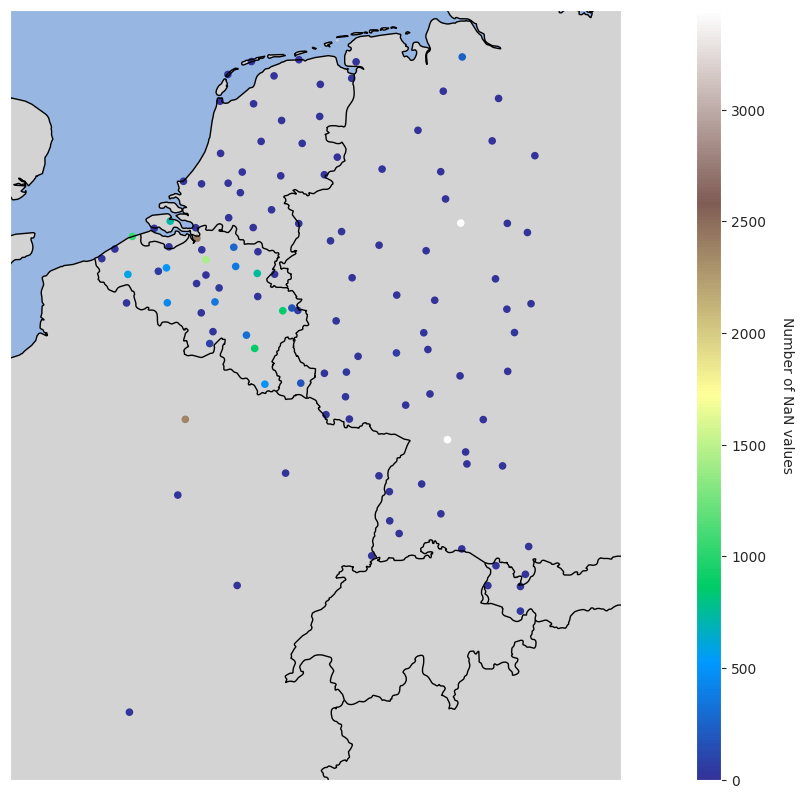

In [29]:
plt.figure(1, figsize=(10, 10))
ax = plot_map()

plot = ax.scatter(stations['lon'], stations['lat'], c=nan_values, cmap='terrain', s=20)
norm = plt.Normalize(vmin=min(nan_values), vmax=max(nan_values))
sm_nodes = plt.cm.ScalarMappable(cmap="terrain", norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.08)
#colbar.ax.set_ylabel(r'$\mathrm{Number of NaN values}$', rotation=270, labelpad=20)
colbar.ax.set_ylabel('Number of NaN values', rotation=270, labelpad=20)

## Distribution of distances

In [4]:
geo_mat = compute_mat(stations, "geo")
alt_mat = compute_mat(stations, "alt")
orog_mat = compute_mat(stations, "alt-orog")
d4mat = compute_mat(station_df=stations, mode="dist4", sum_stats=True, train_set=train, train_target_set=train_target)
d2mat = load_d2_distances(stations, train, True)
rounded2 = d2mat.flatten()
d3mat = load_d3_distances(stations, train, train_target, True)
rounded3 = d3mat.flatten()

[INFO] Loading distances from file...
[INFO] Loading distances from file...
[INFO] Loading distances from file...
[INFO] Loading distances from file...


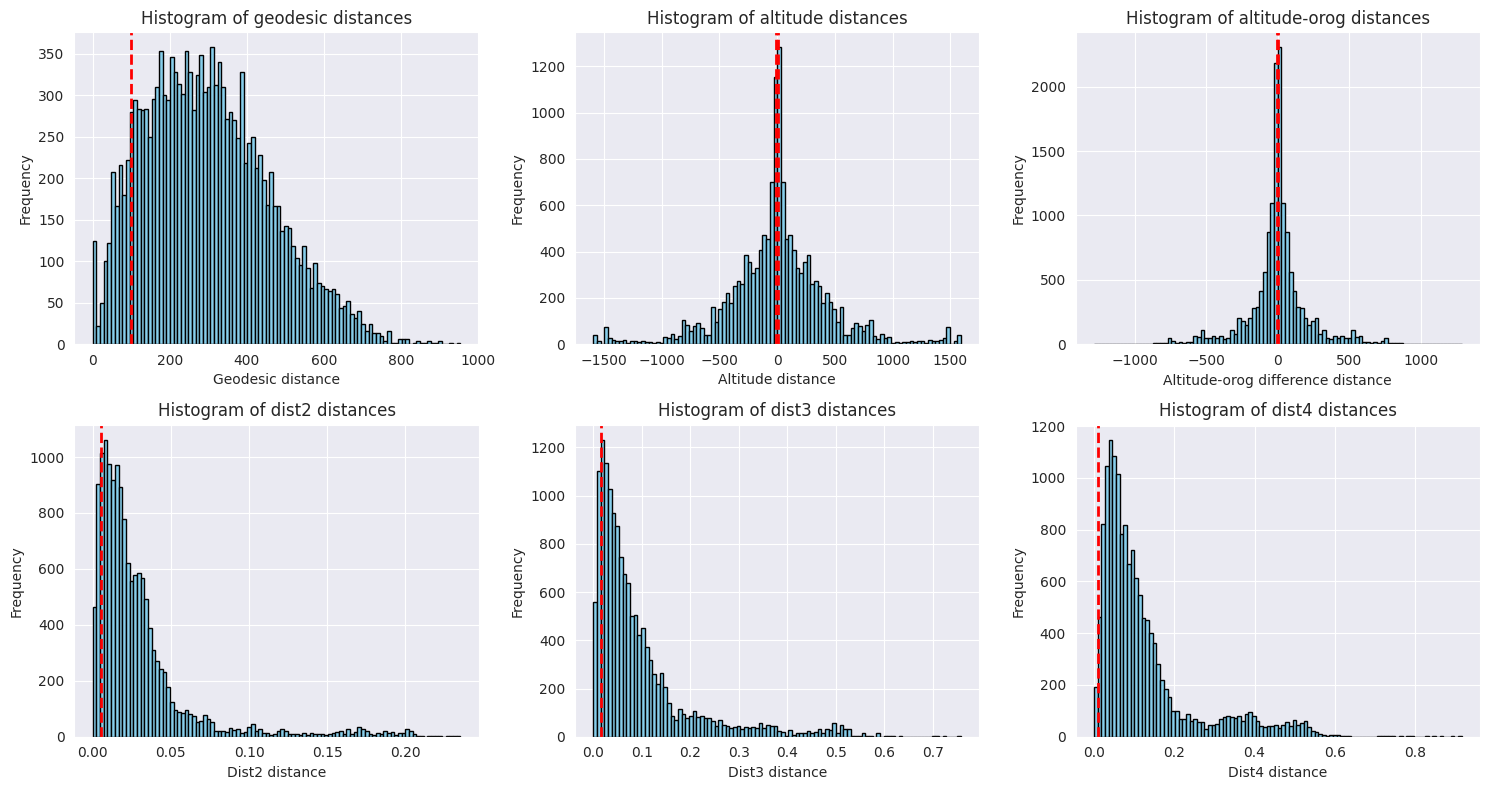

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

axes[0].hist(geo_mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[0].axvline([100], color='red', linestyle='--', linewidth=2)
axes[0].set_title(f"Histogram of geodesic distances")
axes[0].set_xlabel('Geodesic distance')
axes[0].set_ylabel('Frequency')

axes[1].hist(alt_mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[1].axvline([-6.5], color='red', linestyle='--', linewidth=2)
axes[1].axvline([6.5], color='red', linestyle='--', linewidth=2)
axes[1].set_title(f"Histogram of altitude distances")
axes[1].set_xlabel('Altitude distance')
axes[1].set_ylabel('Frequency')

axes[2].hist(orog_mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[2].axvline([-2.5], color='red', linestyle='--', linewidth=2)
axes[2].axvline([2.5], color='red', linestyle='--', linewidth=2)
axes[2].set_title(f"Histogram of altitude-orog distances")
axes[2].set_xlabel('Altitude-orog difference distance')
axes[2].set_ylabel('Frequency')

axes[3].hist(d2mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[3].axvline([0.005], color='red', linestyle='--', linewidth=2)
axes[3].set_title(f"Histogram of dist2 distances")
axes[3].set_xlabel('Dist2 distance')
axes[3].set_ylabel('Frequency')

axes[4].hist(d3mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[4].axvline([0.015], color='red', linestyle='--', linewidth=2)
axes[4].set_title(f"Histogram of dist3 distances")
axes[4].set_xlabel('Dist3 distance')
axes[4].set_ylabel('Frequency')

axes[5].hist(d4mat.flatten(), bins=100, color='skyblue', edgecolor='black')
axes[5].axvline([0.01], color='red', linestyle='--', linewidth=2)
axes[5].set_title(f"Histogram of dist4 distances")
axes[5].set_xlabel('Dist4 distance')
axes[5].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

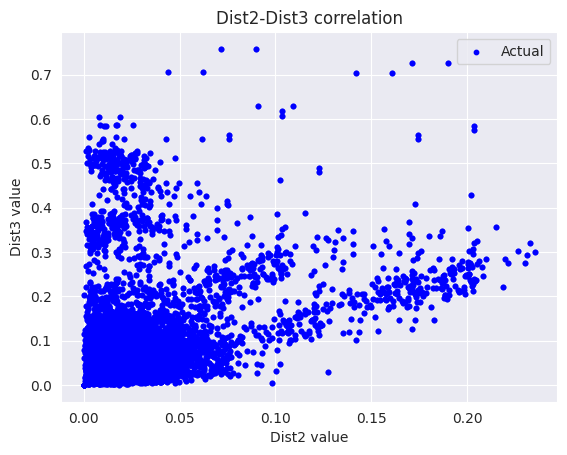

In [11]:
plt.scatter(rounded2, rounded3, color='blue', s=10, label='Actual')
x_values = [min(rounded2), max(rounded2)]
y_values = [min(rounded3), max(rounded3)]
# plt.plot(x_values, y_values, color='red', label='Perfectly correlated')
plt.title('Dist2-Dist3 correlation')
plt.xlabel('Dist2 value')
plt.ylabel('Dist3 value')
plt.legend()
plt.show()
# which are the point for station 62 and 74?

## Check distance of 0 in dist3

In [15]:
np.unravel_index(np.argmax(d3mat), d3mat.shape)

(62, 119)

In [17]:
# check if get_emp_cdf works
id = 62
S = np.arange(-30,30, 1)
i_train = train[train['station_id'] == id]
i_target_temps = train_target[train_target['station_id'] == id]['t2m']
print(i_train.shape)
print(i_target_temps.shape)
print(S.shape)
# cdf_values = np.zeros(S.shape)
# for idx, x in enumerate(S):
#     value = create_emp_cdf_of_errors(i_train, i_target_temps)(x)
#     cdf_values[idx] = value
# print(cdf_values)
# print(cdf_values.shape)

cdfs = []

for i_id in range(0, 122):
    i_train = train[train['station_id'] == i_id]
    i_target_temps = train_target[train_target['station_id'] == i_id]['t2m']
    G_s = create_emp_cdf_of_errors(i_train, i_target_temps)
    cdfs.append(G_s)
list_of_all_G_i_values = []
for G_i in tqdm(cdfs):
    cdf_values = np.zeros(S.shape)
    for idx, x in enumerate(S):
        cdf_values[idx] = G_i(x)
    # print(cdf_values)
    list_of_all_G_i_values.append(cdf_values)
    # print(len(list_of_all_G_i_values))


print(all(f is cdfs[0] for f in cdfs))

# plt.figure(figsize=(8, 4))
# plt.step(S.T, cdf_values, where='post', label='Empirical CDF')
# plt.title('Empirical CDF of Forecast Errors')
# plt.xlabel('Error')
# plt.ylabel('CDF')
# plt.grid(True)
# plt.legend()
# plt.show()

(37928, 36)
(3448,)
(60,)


100%|██████████| 122/122 [02:58<00:00,  1.46s/it]

False


In [ ]:
all(np.array_equal(list_of_all_G_i_values[0], arr) for arr in list_of_all_G_i_values)
# print(list_of_all_G_i_values)
print(np.sort(d3mat))
print(np.argsort(d3mat))


In [ ]:
plt.figure(figsize=(8, 4))
plt.step(S.T, list_of_all_G_i_values[119], where='post', label='Empirical CDF')
plt.title('Empirical CDF of Forecast Errors')
plt.xlabel('Error')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for idx, array in enumerate(list_of_all_G_i_values):
    if np.all(array == 0):
        print(idx)


In [ ]:
graphs_train_rf, tests = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], sum_stats = True)

graphs_test_rf, graphs_test_f = tests
graphs_test = graphs_test_rf